In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [3]:
file_path = './data/assignmentImageDenoising_phantom.mat'
mat = scipy.io.loadmat(file_path)

In [4]:
print(mat.keys())
Noisy = mat['imageNoisy']
Original = mat['imageNoiseless']
print(f"header: {mat['__header__']}")
print(f"version: {mat['__version__']}")
print(f"globals: {mat['__globals__']}")
print(f"Noisy.shape: {Noisy.shape}")
print(f"Original.shape: {Original.shape}")

dict_keys(['__header__', '__version__', '__globals__', 'imageNoiseless', 'imageNoisy'])
header: b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Jan 27 00:08:21 2021'
version: 1.0
globals: []
Noisy.shape: (256, 256)
Original.shape: (256, 256)


Figure(640x480)


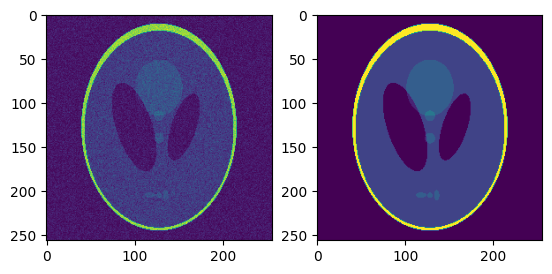

In [5]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(Noisy)
# axs[0].title('Noisy Brain MRI')
axs[1].imshow(Original)
# axs[1].title('Original Brain MRI')
print(fig)

In [6]:
# Noise Model
# We have picked Gaussian Noise model here
def noise_model(x, y):
    noise = np.abs(x-y)**2
    del_noise = 2*(x-y)
    return noise, del_noise

In [8]:
# Quadratic prior
def quadratic_prior(x, y, gamma=None):
    quad_prior = (np.abs(x-y))**2
    del_quad_prior = 2 * np.abs(x-y)
    return quad_prior, del_quad_prior

# Discontinuity-adaptive Huber prior
def adaptive_huber(x, y, gamma):
    u = np.abs(x-y)
    huber = np.where(u <= gamma, 0.5 * u**2, gamma * u - 0.5 * gamma**2)
    del_huber = np.where(u <= gamma, u, gamma)
    
    return huber, del_huber

# Discontinuity-adaptive prior
def disco_adaptive(x, y, gamma):
    u = np.abs(x-y)
    disco_adap = gamma*u - gamma**2 * np.log(1 + u/gamma)
    del_disco_adap = gamma - gamma/(gamma + u)

    return disco_adap, del_disco_adap

In [9]:
# Calculating the prior for entire image:
def calc_prior(x, y, prior, gamma=None):
    # Roll the entire image by 1 unit in the corresponding directions and compute V(x)
    left, del_left = prior(x, np.roll(x, -1, axis=1), gamma)
    right, del_right = prior(x, np.roll(x, 1, axis=1), gamma)
    up, del_up = prior(x, np.roll(x, 1, axis=0), gamma)
    down, del_down = prior(x, np.roll(x, -1, axis=0), gamma)
    
    # Sum of V(x) over all cliques
    prior = left + right + up + down

    # Sum of derivative of V(x) over all cliques   
    del_prior = del_left + del_right + del_up + del_down

    return prior, del_prior

# Calculating the posterior:
def calc_posterior(x, y, prior_func, alpha, gamma=None):
    likelihood, del_likelihood = noise_model(x, y)
    prior, del_prior = calc_prior(x, y, prior_func, gamma)

    posterior = (1-alpha) * likelihood + alpha * prior
    del_posterior = (1-alpha) * del_likelihood + alpha * del_prior

    return posterior, del_posterior

In [10]:
X = Noisy.copy()
Y = Noisy.copy()

In [11]:
# Function for RRMSE:
def rrmse(A,B):
    #Here A and B is noiseless image and noisy image
    num=np.sum((np.abs(A)-np.abs(B))**2)
    den=np.sum(np.abs(A)**2)
    rrmse=np.sqrt(num/den)
    return rrmse 

In [12]:
# Calculate RRMSE for the initial Noisy and Original image here
print(rrmse(Original, Noisy))

0.29857915712437444


In [76]:
# Gradient Ascent
def gradient_ascent(y, prior_func, alpha, gamma, max_iters=100, tol=1e-5):

    x = y.copy()  # Initialize with the noisy image
    step_size = 0.1  # Dynamic step size
    prev_posterior, _ = calc_posterior(x, y, prior_func, alpha, gamma)

    iter = []
    objective = []
    for i in range(max_iters):
        posterior, grad_posterior = calc_posterior(x, y, prior_func, alpha, gamma)
        iter.append(i)
        objective.append(rrmse(x, Original))
        # print(f"posterior: {posterior[100]}")
        prior, del_prior = calc_prior(x, y, prior_func, gamma)
        # print(f"prior: {prior[100]}")
        # Gradient ascent update
        x_new = x - step_size * grad_posterior
        # print(f"RRMSE: {rrmse(x_new, Original)}, step-size: {step_size}")
        # Compute new posterior
        new_posterior, _ = calc_posterior(x_new, y, prior_func, alpha, gamma)
        # print(f"posterior: {new_posterior}")

        if np.sum(new_posterior) < np.sum(prev_posterior):
            step_size *= 1.1 
            x = x_new
            prev_posterior = new_posterior
        else:
            step_size *= 0.8 
        
        # Convergence check
        if np.linalg.norm(grad_posterior) < tol:
            print(f"Converged in {i+1} iterations")
            break
    rrmse_val = rrmse(x, Original)
    print(f"RRMSE: {rrmse_val}")
    return x, iter, objective, rrmse_val

RRMSE: 0.27754251169635413
(256, 256)


Text(0.5, 1.0, 'Denoised')

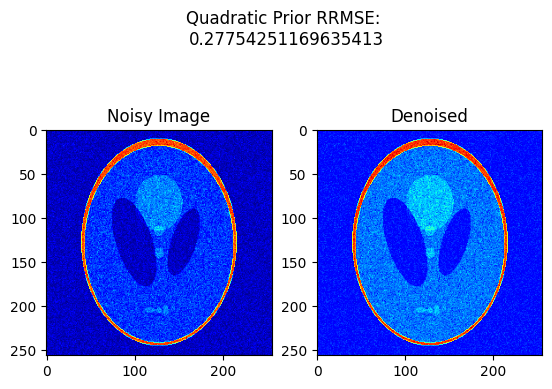

In [93]:
a_opt = 0.9
denoised_quad, iter, objective, rrmse_val = gradient_ascent(Noisy, quadratic_prior, alpha=0.9, gamma=None)
print(denoised_quad.shape)

fig, axs = plt.subplots(1, 2)
plt.suptitle(f"Quadratic Prior RRMSE: \n{rrmse_val}")

axs[0].imshow(Noisy, cmap='jet')
axs[0].set_title('Noisy Image')
axs[1].imshow(denoised_quad, cmap='jet')
axs[1].set_title('Denoised')

In [94]:
a, b, c, rrmse_val_opt = gradient_ascent(Noisy, quadratic_prior, alpha=a_opt, gamma=g_opt)
a, b, c, rrmse_val1 = gradient_ascent(Noisy, quadratic_prior, alpha=1.2*a_opt, gamma=g_opt)
a, b, c, rrmse_val2 = gradient_ascent(Noisy, quadratic_prior, alpha=0.8*a_opt, gamma=g_opt)

print(f"a*: {a_opt},, RRMSE(a*,g*): {rrmse_val_opt}")
print(f"RRMSE(1.2a*,g*): {rrmse_val1}")
print(f"RRMSE(0.8a*,g*): {rrmse_val2}")

RRMSE: 0.27754251169635413
RRMSE: 0.2780574239763444
RRMSE: 0.27754251169635413
a*: 0.9,, RRMSE(a*,g*): 0.27754251169635413
RRMSE(1.2a*,g*): 0.2780574239763444
RRMSE(0.8a*,g*): 0.27754251169635413


RRMSE: 0.2775193200655295
(256, 256)


Text(0.5, 1.0, 'Denoised')

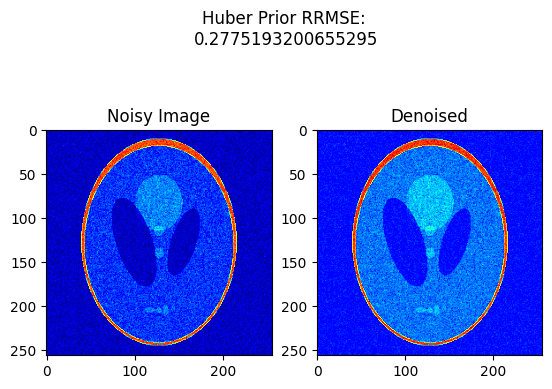

In [91]:
a_opt, g_opt = 0.9, 5
denoised_huber, iter, objective, rrmse_val = gradient_ascent(Noisy, adaptive_huber, alpha=a_opt, gamma=g_opt)
print(denoised_huber.shape)

fig, axs = plt.subplots(1, 2)
plt.suptitle(f"Huber Prior RRMSE: \n{rrmse_val}")

axs[0].imshow(Noisy, cmap='jet')
axs[0].set_title('Noisy Image')
axs[1].imshow(denoised_huber, cmap='jet')
axs[1].set_title('Denoised')

In [92]:
a, b, c, rrmse_val_opt = gradient_ascent(Noisy, adaptive_huber, alpha=a_opt, gamma=g_opt)
a, b, c, rrmse_val1 = gradient_ascent(Noisy, adaptive_huber, alpha=1.2*a_opt, gamma=g_opt)
a, b, c, rrmse_val2 = gradient_ascent(Noisy, adaptive_huber, alpha=0.8*a_opt, gamma=g_opt)
a, b, c, rrmse_val3 = gradient_ascent(Noisy, adaptive_huber, alpha=a_opt, gamma=1.2*g_opt)
a, b, c, rrmse_val4 = gradient_ascent(Noisy, adaptive_huber, alpha=a_opt, gamma=0.8*g_opt)

print(f"a*: {a_opt},g*: {g_opt}, RRMSE(a*,g*): {rrmse_val_opt}")
print(f"RRMSE(1.2a*,g*): {rrmse_val1}")
print(f"RRMSE(0.8a*,g*): {rrmse_val2}")
print(f"RRMSE(a*,1.2g*): {rrmse_val3}")
print(f"RRMSE(a*,0.8g*): {rrmse_val4}")

RRMSE: 0.2775193200655295
RRMSE: 0.2779505673627034
RRMSE: 0.2776138945241672
RRMSE: 0.2775193200655295
RRMSE: 0.2775193200655295
a*: 0.9,g*: 5, RRMSE(a*,g*): 0.2775193200655295
RRMSE(1.2a*,g*): 0.2779505673627034
RRMSE(0.8a*,g*): 0.2776138945241672
RRMSE(a*,1.2g*): 0.2775193200655295
RRMSE(a*,0.8g*): 0.2775193200655295


RRMSE: 0.25556865777468385
(256, 256)


Text(0.5, 1.0, 'Denoised')

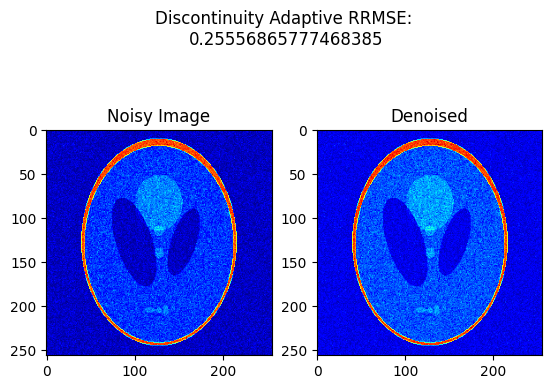

In [84]:
a_opt, g_opt = 0.87, 1.1
denoised_disco, iter, objective, rrmse_val = gradient_ascent(Noisy, disco_adaptive, alpha=a_opt, gamma=g_opt)
print(denoised_disco.shape)

fig, axs = plt.subplots(1, 2)
plt.suptitle(f"Discontinuity Adaptive RRMSE: \n{rrmse_val}")

axs[0].imshow(Noisy, cmap='jet')
axs[0].set_title('Noisy Image')
axs[1].imshow(denoised_disco, cmap='jet')
axs[1].set_title('Denoised')

In [86]:
# Proof of optimality
a, b, c, rrmse_val_opt = gradient_ascent(Noisy, disco_adaptive, alpha=a_opt, gamma=g_opt)
a, b, c, rrmse_val1 = gradient_ascent(Noisy, disco_adaptive, alpha=1.2*a_opt, gamma=g_opt)
a, b, c, rrmse_val2 = gradient_ascent(Noisy, disco_adaptive, alpha=0.8*a_opt, gamma=g_opt)
a, b, c, rrmse_val3 = gradient_ascent(Noisy, disco_adaptive, alpha=a_opt, gamma=1.2*g_opt)
a, b, c, rrmse_val4 = gradient_ascent(Noisy, disco_adaptive, alpha=a_opt, gamma=0.8*g_opt)

print(f"a*: {a_opt},g*: {g_opt}, RRMSE(a*,g*): {rrmse_val_opt}")
print(f"RRMSE(1.2a*,g*): {rrmse_val1}")
print(f"RRMSE(0.8a*,g*): {rrmse_val2}")
print(f"RRMSE(a*,1.2g*): {rrmse_val3}")
print(f"RRMSE(a*,0.8g*): {rrmse_val4}")


RRMSE: 0.25556865777468385
RRMSE: 0.28475233485835066
RRMSE: 0.2682266341028017
RRMSE: 0.26340858134200484
RRMSE: 0.32400692164724615
a*: 0.87,g*: 1.1, RRMSE(a*,g*): 0.25556865777468385
RRMSE(1.2a*,g*): 0.28475233485835066
RRMSE(0.8a*,g*): 0.2682266341028017
RRMSE(a*,1.2g*): 0.26340858134200484
RRMSE(a*,0.8g*): 0.32400692164724615


In [28]:
print(objective)

[0.2829961608957733, 0.2829961608957733, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.27252927362232215, 0.272529273622

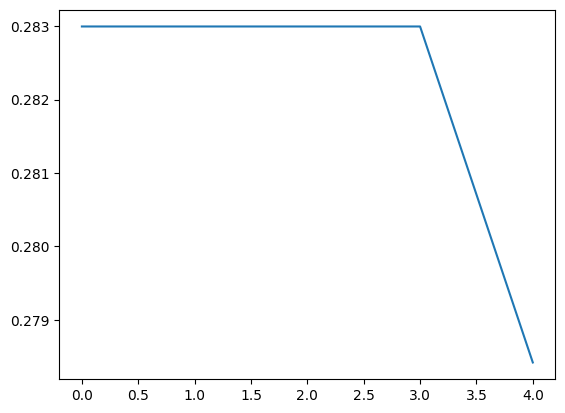

In [68]:
plt.plot(iter[:5], objective[:5])